## Konstrukcje kompleksów symplicjalnych

In [93]:
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from itertools import combinations

In [110]:
# Zbiór punktów
points = np.array([[0.4, 0.55], [0.2,0.09], [0.03, 0.33], [0.2, 0.38], [0.92, 0.88], [0.95, 0.6], [0.7, 0.75], [0.6, 0.4], 
                   [0.5, 0.8], [0.1,0.9], [0.05, 0.78], [0.3, 0.7]])
       
# Macierz odległości
dist_matrix = distance_matrix(points, points)

# Listy parametrów
epsilon_list = [0.1, 0.2, 0.3, 0.4]
r = [m/2 for m in epsilon_list]

# Funkcja sprawdzająca, czy okręgi się przecinają
def intersection(indices, points, epsilon):
    
    subset = points[list(indices)]
    
    # Sprawdzamy czy każda para punktów ma odległość <= 2*epsilon
    for p1, p2 in combinations(subset, 2):
        if np.linalg.norm(p1 - p2) > 2 * epsilon:
            return False
    
    # Warunek przecięcia trzech kul - rozwiązujemy układ równań
    A = 2 * (subset[1:] - subset[0])  # Macierz różnic współrzędnych
    b = np.sum(subset[1:]**2 - subset[0]**2, axis=1)  # Równanie okręgu
    
    try:
        center = np.linalg.solve(A, b)  # Środek sferycznego przecięcia
        return all(np.linalg.norm(center - p) <= epsilon for p in subset)
    except np.linalg.LinAlgError:
        return False  # Jeśli macierz jest osobliwa (punkty współliniowe), nie ma przecięcia

### Kompleks Vietorisa-Ripsa

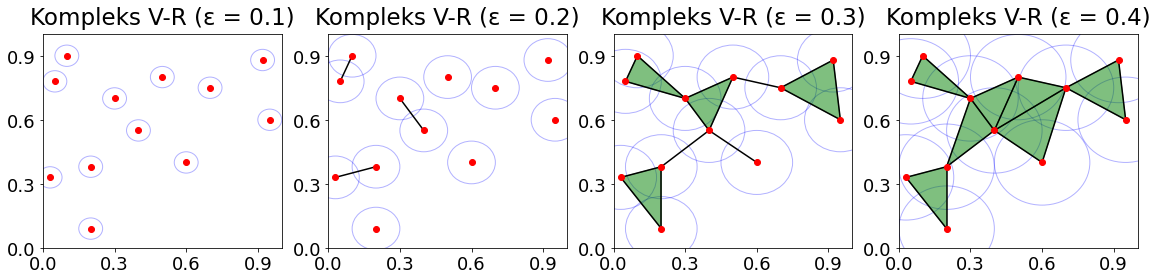

In [126]:
# Tworzenie struktury wykresu
fig, axes = plt.subplots(1, len(epsilon_list), figsize=(16, 4))

# Pętla tworząca kompleks Vietoria-Ripsa
for idx, threshold in enumerate(epsilon_list):
    
    # Tworzenie osobnych wykresów
    ax = axes[idx]
    
    # Tworzenie kompleksu 
    rips = gd.RipsComplex(points=points, max_edge_length=threshold)
    
    # Wyizolowanie krawędzi i trójkątów
    simplex_tree = rips.create_simplex_tree(max_dimension=2)
    edges = [s for s in simplex_tree.get_skeleton(1) if len(s[0]) == 2]
    triangles = [s for s in simplex_tree.get_skeleton(2) if len(s[0]) == 3]
    
    # Tworzenie punktów na wykresach
    ax.scatter(points[:, 0], points[:, 1], color='red', zorder=2)
    
    # Tworzenie okręgów wokół punktów
    for p in points:
        circle = plt.Circle((p[0], p[1]), threshold/2, color='blue', fill=False, alpha=0.3)
        ax.add_patch(circle)
        
    # Tworzenie krawędzi
    for edge, _ in edges:
        p1, p2 = points[edge[0]], points[edge[1]]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k-', zorder=1)

    # Tworzenie trójkątów
    for tri, _ in triangles:
        p1, p2, p3 = points[tri[0]], points[tri[1]], points[tri[2]]
        ax.fill([p1[0], p2[0], p3[0]], [p1[1], p2[1], p3[1]], color='green', alpha=0.5)

    # Parametry wykresów
    ax.set_title(f"Kompleks V-R (ε = {threshold})", fontsize=23, pad=10)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 0.3, 0.6, 0.9])
    ax.set_xticks([0, 0.3, 0.6, 0.9])
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)

# Wyświetlenie i zapisanie wykresu
plt.tight_layout()
#plt.savefig("VietorisRips.pdf", bbox_inches='tight')
plt.show()

### Kompleks Cecha

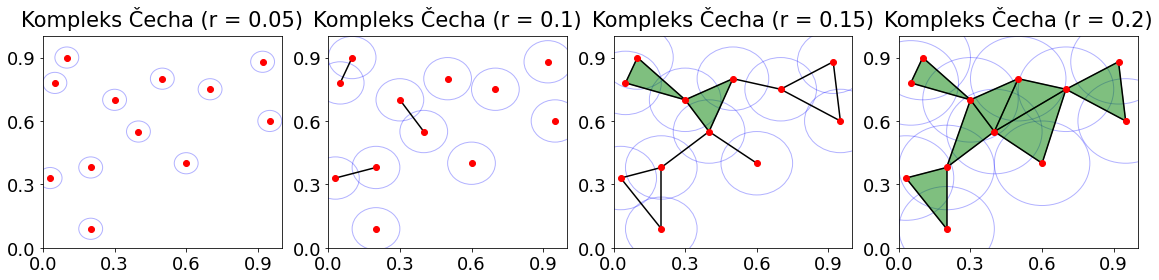

In [123]:
# Tworzenie struktury wykresu
fig, axes = plt.subplots(1, len(r), figsize=(16,4))

# Pętla tworząca kompleks Cecha
for idx, epsilon in enumerate(r):
    
    # Tworzenie osobnych wykresów
    ax = axes[idx]
    
    # Tworzenie punktów na wykresach
    ax.scatter(points[:, 0], points[:, 1], color='red', zorder=2)
    
    # Wyznacznie sympleksów w kompleksie Cecha za pomocą funkcji intersection
    simplex_tree = gd.SimplexTree()
    for i in range(len(points)):
        simplex_tree.insert([i], filtration=0.0)
        for j in range(i + 1, len(points)):
            if dist_matrix[i, j] <= 2 * epsilon:
                simplex_tree.insert([i, j], filtration=epsilon)
            for k in range(j + 1, len(points)):
                if intersection([i, j, k], points, epsilon):
                    simplex_tree.insert([i, j, k], filtration=epsilon)

    # Tworzenie okręgów wokół punktów
    for p in points:
        circle = plt.Circle((p[0], p[1]), epsilon, color='blue', fill=False, alpha=0.3)
        ax.add_patch(circle)

    # Tworzenie krawędzi
    for simplex, _ in simplex_tree.get_skeleton(1):
        if len(simplex) == 2:
            p1, p2 = points[simplex[0]], points[simplex[1]]
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k-', zorder=1)

    # Tworzenie trójkątów
    for simplex, _ in simplex_tree.get_skeleton(2):
        if len(simplex) == 3:
            p1, p2, p3 = points[simplex[0]], points[simplex[1]], points[simplex[2]]
            ax.fill([p1[0], p2[0], p3[0]], [p1[1], p2[1], p3[1]], color='green', alpha=0.5)

    # Parametry wykresów
    ax.set_title(f"Kompleks Čecha (r = {epsilon})", fontsize=21, pad=10)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 0.3, 0.6, 0.9])
    ax.set_xticks([0, 0.3, 0.6, 0.9])
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)

# Wyświetlenie i zapisanie wykresu
plt.tight_layout()
#plt.savefig("Cech.pdf", bbox_inches='tight')
plt.show()

### PORÓWNANIE CECHA I VIETORISA RIPSA

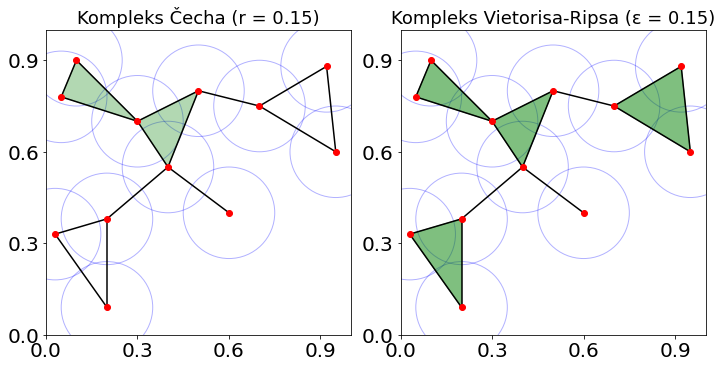

In [108]:
# Lista punktów
points = np.array([[0.4, 0.55], [0.2,0.09], [0.03, 0.33], [0.2, 0.38], [0.92, 0.88], [0.95, 0.6], [0.7, 0.75], [0.6, 0.4], 
                   [0.5, 0.8], [0.1,0.9], [0.05, 0.78], [0.3, 0.7]])

# Macierz odległości
dist_matrix = distance_matrix(points, points)

# Lista parametrów
epsilons = [0.15, 0.15]

# Lista tytułów
titles = [f"Kompleks Čecha (r = {epsilons[0]})", f"Kompleks Vietorisa-Ripsa (ε = {epsilons[1]})"]#, f"Čech (r = {epsilons[2]})"]

# Tworzenie wykresu
fig, axes = plt.subplots(1, len(epsilons), figsize=(10, 5))

# Pętla tworząca kompleksy
for idx, epsilon in enumerate(epsilons):
    
    # Tworzenie kompleksu Cecha
    if idx%2==0:
        
        # Tworzenie osobnych wykresów
        ax = axes[idx]
        
        # Tworzenie punktów na wykresach
        ax.scatter(points[:, 0], points[:, 1], color='red', zorder=2)
        
        # Wyznacznie sympleksów w kompleksie Cecha za pomocą funkcji intersection
        simplex_tree = gd.SimplexTree()
        for i in range(len(points)):
            simplex_tree.insert([i], filtration=0.0)
            for j in range(i + 1, len(points)):
                if dist_matrix[i, j] <= 2 * epsilon:
                    simplex_tree.insert([i, j], filtration=epsilon)
                for k in range(j + 1, len(points)):
                    if intersection([i, j, k], points, epsilon):
                        simplex_tree.insert([i, j, k], filtration=epsilon)
                        
        # Tworzenie okręgów wokół punktów
        for p in points:
            circle = plt.Circle((p[0], p[1]), epsilon, color='blue', fill=False, alpha=0.3)
            ax.add_patch(circle)

        # Tworzenie krawędzi
        for simplex, _ in simplex_tree.get_skeleton(1):
            if len(simplex) == 2:
                p1, p2 = points[simplex[0]], points[simplex[1]]
                ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k-', zorder=1)
                
        # Tworzenie trójkątów
        for simplex, _ in simplex_tree.get_skeleton(2):
            if len(simplex) == 3:
                p1, p2, p3 = points[simplex[0]], points[simplex[1]], points[simplex[2]]
                ax.fill([p1[0], p2[0], p3[0]], [p1[1], p2[1], p3[1]], color='green', alpha=0.3)
    
    # Tworzenie kompleksu Vietorisa-Ripsa
    else:
        
        # Tworzenie osobnych wykresów
        ax = axes[idx]
    
        # Tworzenie kompleksu 
        rips = gd.RipsComplex(points=points, max_edge_length=2*epsilons[idx])
        
        # Wyizolowanie krawędzi i trójkątów
        simplex_tree = rips.create_simplex_tree(max_dimension=2)
        edges = [s for s in simplex_tree.get_skeleton(1) if len(s[0]) == 2]
        triangles = [s for s in simplex_tree.get_skeleton(2) if len(s[0]) == 3]

        # Tworzenie punktów na wykresach
        ax.scatter(points[:, 0], points[:, 1], color='red', zorder=2)
        
        # Tworzenie okręgów wokół punktów
        for p in points:
            circle = plt.Circle((p[0], p[1]), epsilon, color='blue', fill=False, alpha=0.3)
            ax.add_patch(circle)

        # Tworzenie krawędzi
        for edge, _ in edges:
            p1, p2 = points[edge[0]], points[edge[1]]
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k-', zorder=1)

        # Tworzenie trójkątów
        for tri, _ in triangles:
            p1, p2, p3 = points[tri[0]], points[tri[1]], points[tri[2]]
            ax.fill([p1[0], p2[0], p3[0]], [p1[1], p2[1], p3[1]], color='green', alpha=0.5)

    # Parametry wykresów
    ax.set_title(titles[idx], fontsize=18)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')
    ax.set_yticks([0, 0.3, 0.6, 0.9])
    ax.set_xticks([0, 0.3, 0.6, 0.9])
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)

# Wyświetlenie i zapisanie wykresu
plt.tight_layout()
#plt.savefig("Porównanie.pdf", bbox_inches='tight')
plt.show()

## Kod do tworzenia sympleksów i kompleksów symplicjalnych

Kod inspirowany z githuba
https://github.com/iaciac/py-draw-simplicial-complex/blob/master/Draw%202d%20simplicial%20complex.ipynb, zmodyfikowany z dodanymi hiperparametrami: <br>
SEED - ziarno, z którego pakiet networkx ma wybierać punkty <br>
ANNOT - czy punkty w sympleksach mają być podpisane <br>
ANNOTedges - czy krawędzie w sympleksach mają być podpisane <br>
ANNOTsize - wielkość podpisów dla punktów/krawędzi <br>
ORIENT - czy krawędzie w sympleksach mają być zorientowane <br>
ORIENTT - czy trójkąty w sympleksach mają być zorientowane <br>
WRONG - czy kompleks symplicjalny ma być błędny

In [16]:
import networkx as nx
import itertools
import random 
from typing import Optional
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, FancyArrow, Arc
%matplotlib inline 
random.seed(246)

def draw_2d_simplicial_complex(simplices, fixedpos: Optional[dict] = None, ax = None, SEED=1, ANNOT=False, ANNOTedges=False,
                               ANNOTsize=8, ORIENT=False, ORIENTT=False, WRONG=False):
    
    # Wyizolowanie kompleksów 0-wymiarych (punkty), 1-wymiarowych (krawędzie) i 2-wymiarowych (trójkąty)
    nodes =list(set(itertools.chain(*simplices)))
    edges = list(set(itertools.chain(*[[tuple(sorted((i, j))) for i, j in itertools.combinations(simplex, 2)] for simplex in simplices])))
    triangles = list(set(itertools.chain(*[[tuple(sorted((i, j, k))) for i, j, k in itertools.combinations(simplex, 3)] for simplex in simplices])))
    
    # Parametry wykresu
    if ax is None: 
        ax = plt.gca()
    ax.set_xlim([-1.1, 1.1])      
    ax.set_ylim([-1.1, 1.1])
    ax.get_xaxis().set_ticks([])  
    ax.get_yaxis().set_ticks([])
    ax.axis('off')

    # Stworzenie struktury kompleksu - grafu z biblioteki networkx, oraz dodanie wbudowanych w networkx wierzchołków 
    #lub krawędzi w zależności, czy podaliśmy parametry pozycji wierzchołków fixedpos
    if fixedpos!=None:
        G = nx.Graph()
        G.add_nodes_from(nodes)
        G.add_edges_from(edges)
        fixed_positions=fixedpos
        fixed_nodes = fixed_positions.keys()
        pos = nx.spring_layout(G,pos=fixed_positions, fixed = fixed_nodes, seed=SEED) 
    else:
        G = nx.Graph()
        G.add_nodes_from(nodes)
        G.add_edges_from(edges)
        pos = nx.spring_layout(G, seed=SEED)
    
    # Tworzenie wierzchołków kompleksu 
    for i in nodes:
        (x, y) = pos[i]
        circ = plt.Circle([ x, y ], radius = 0.02, zorder = 3, lw=0.5,
                          edgecolor = 'Black', facecolor = u'#ff7f0e')
        ax.add_patch(circ)
        
        # Podpisanie wierzchołków 
        if ANNOT==True:
            ax.annotate(f"$v_{{{i}}}$", xy=(x, y), xytext=(x, y + 0.05),
                        textcoords='data', fontsize=ANNOTsize, color='blue')
        
            
    # Tworzenie 2-wymiarowych sympleksów (trójkątów)
    for i, j, k in triangles:
        (x0, y0) = pos[i]
        (x1, y1) = pos[j]
        (x2, y2) = pos[k]
        tri = plt.Polygon([ [ x0, y0 ], [ x1, y1 ], [ x2, y2 ] ],
                          edgecolor = 'black', facecolor = plt.cm.Blues(0.6),
                          zorder = 2, alpha=0.4, lw=0.5)
        ax.add_patch(tri)
        
        # Dodanie orientacji do trójkątów (za pomocą strzałek)
        if ORIENT==True and ORIENTT:
            xc = (x0 + x1 + x2) / 3
            yc = (y0 + y1 + y2) / 3
            arc_radius = 0.15
            arc_angle_start = 30
            arc_angle_end = 270

            arc = Arc((xc, yc), 2 * arc_radius, 2 * arc_radius, angle=0,
                      theta1=arc_angle_start, theta2=arc_angle_end, color="black", lw=1.5)
            ax.add_patch(arc)

            theta = np.radians(arc_angle_end) 
            arrow_x = xc + arc_radius * np.cos(theta)
            arrow_y = yc + arc_radius * np.sin(theta)
            
            dx = -np.sin(theta) * 0.1
            dy = np.cos(theta) * 0.1

            arrow = FancyArrow(arrow_x, arrow_y, dx, dy, head_width=0.08, head_length=0.08, 
                               length_includes_head=True, color="black")
            ax.add_patch(arrow)
            
    # Parametr sprawdzający, czy ma wyjść poprawny kompleksy symplicjalny
    if WRONG==False:
        for k, (i, j) in enumerate(edges):
            (x0, y0) = pos[i]
            (x1, y1) = pos[j]
            line = plt.Line2D([ x0, x1 ], [y0, y1 ],color = 'black', zorder = 1, lw=0.7)
            ax.add_line(line)
            if ORIENT==True:
                if simplices[k][0]<simplices[k][1]:
                    arrow = FancyArrow(x0, y0, (x1 - x0) * 0.5, (y1 - y0) * 0.5,
                                       color='grey', width=0.001, head_width=0.08, head_length=0.08, zorder=3)
                    ax.add_patch(arrow)
                else:
                    arrow = FancyArrow(x1, y1, (x1 - x0) * -0.5, (y1 - y0) * -0.5,
                                       color='grey', width=0.001, head_width=0.08, head_length=0.08, zorder=3)
                    
                    ax.add_patch(arrow)
                if ANNOTedges==True:
                    ax.annotate(rf"$e_{{{k}}}$" , ((x0 + x1) / 2 -(0.15), (y0 + y1) / 2 +(0.05) ), color='blue',
                                ha='center', va='center', zorder=4, fontsize=ANNOTsize)

## Przykład różnych kompleksów dla tych samych punktów

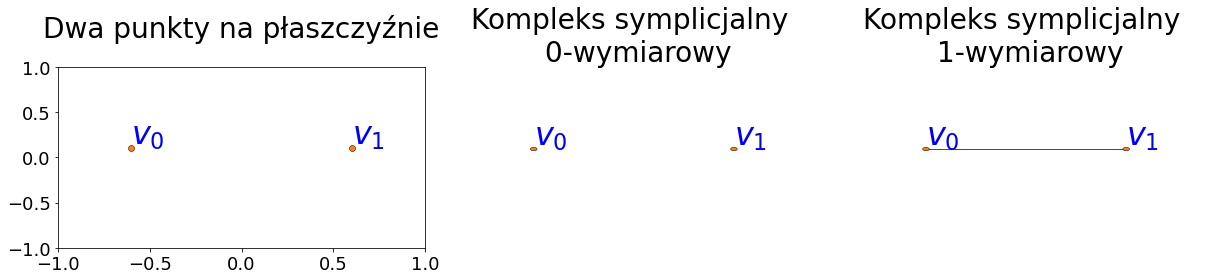

In [62]:
# Tworzenie sympleksów
simplices1 = [[0],[1]]
simplices2 = [[0],[1], [0,1]]

fig, axs = plt.subplots(1, 3, figsize=(17, 4)) 

# Wykres 1 - dwa wybrane punkty
axs[0].scatter([-0.6, 0.6], [1/10, 1/10], edgecolor = 'Black', lw=0.5, facecolor = u'#ff7f0e')

# Parametry wykresu
axs[0].set_xlim(-1,1)
axs[0].set_ylim(-1,1)
axs[0].tick_params(axis='x', labelsize=18)
axs[0].tick_params(axis='y', labelsize=18)

# Podpisy punktów
axs[0].annotate(f"$v_{{{0}}}$", xy=(-0.6, 1/10), xytext=(-0.6, 1/10 + 0.05), textcoords='data', fontsize=32, color='blue')
axs[0].annotate(f"$v_{{{1}}}$", xy=(0.6, 1/10), xytext=(0.6, 1/10 + 0.05), textcoords='data', fontsize=32, color='blue')

# Wykres 2 - kompleks 0-wymiarowy dla dwóch wybranych punktów
axs[0].set_title("Dwa punkty na płaszczyźnie", fontsize=28, pad=30)
draw_2d_simplicial_complex(simplices1, ax=axs[1], fixedpos = {0:(-0.6,1/10), 1:(0.6,1/10)}, ANNOT=True, ANNOTsize=32)
axs[1].set_title("Kompleks symplicjalny \n 0-wymiarowy", fontsize=28)


# Wykres 3 - kompleks 1-wymiarowy dla dwóch wybranych punktów
draw_2d_simplicial_complex(simplices2, ax=axs[2], fixedpos = {0:(-0.6,1/10), 1:(0.6,1/10)}, ANNOT=True, ANNOTsize=32)
axs[2].set_title("Kompleks symplicjalny \n 1-wymiarowy", fontsize=28)

# Wyświetlenie i zapisanie wykresu
plt.tight_layout()
#plt.savefig("Różnekompleksy.pdf", bbox_inches='tight')
plt.show()

## Przykłady różnowymiarowych sympleksów

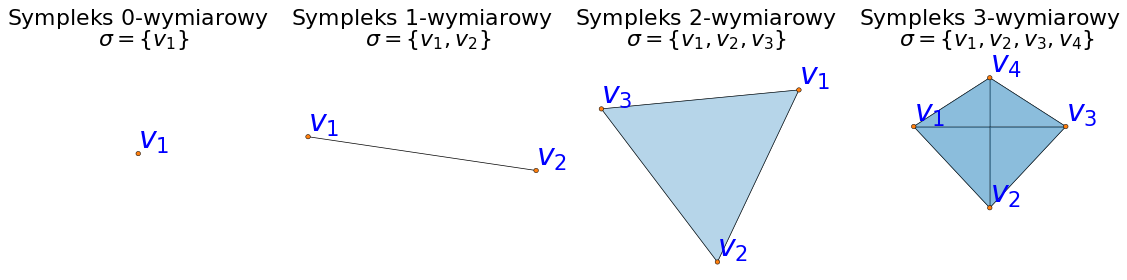

In [91]:
# Tworzenie sympleksów
simplices1 = [[1]]
simplices2 = [[1,2]]
simplices3 = [[1,2,3]]
simplices4 = [[1,2], [2,3], [3,4], [4,1], [1,3], [2,4], [1,3,4], [1,2,3], [1,2,4], [2,3,4]]

# Tworzenie struktury wykresu
fig, axs = plt.subplots(1, 4, figsize=(16, 4)) 

# Wykres 1 - sympleks 0-wymiarowy
draw_2d_simplicial_complex(simplices1, ax=axs[0], SEED=6, ANNOT=True, ANNOTsize=30)
axs[0].set_title(r"Sympleks $0$-wymiarowy", fontsize=22, pad=10)
axs[0].annotate(r"$\sigma = \{v_1\}$", (-0.35,1), fontsize=22)

# Wykres 2 - sympleks 1-wymiarowy
draw_2d_simplicial_complex(simplices2, ax=axs[1], SEED=7, ANNOT=True, ANNOTsize=30)
axs[1].set_title(r"Sympleks $1$-wymiarowy", fontsize=22, pad=10)
axs[1].annotate(r"$\sigma = \{v_1, v_2\}$", (-0.5,1), fontsize=22)

# Wykres 3 - sympleks 2-wymiarowy
draw_2d_simplicial_complex(simplices3, ax=axs[2], SEED=6, ANNOT=True, ANNOTsize=30)
axs[2].set_title(r"Sympleks $2$-wymiarowy", fontsize=22, pad=10)
axs[2].annotate(r"$\sigma = \{v_1, v_2, v_3\}$", (-0.7,1), fontsize=22)

# Wykres 4 - sympleks 3-wymiarowy
draw_2d_simplicial_complex(simplices4, ax=axs[3], fixedpos = {1:(-2/3,1/4), 2:(0,-5/10), 3:(2/3,1/4), 4:(0,7/10)}, 
                           ANNOT=True, ANNOTsize=30)
axs[3].set_title(r"Sympleks $3$-wymiarowy", fontsize=22, pad=10)
axs[3].annotate(r"$\sigma = \{v_1, v_2, v_3, v_4\}$", (-0.8,1), fontsize=22)

# Wyświetlenie i zapisanie wykresu
plt.tight_layout()
#plt.savefig("PrzykładoweSympleksy.pdf", bbox_inches='tight')
plt.show()

## Opis ścian sympleksu

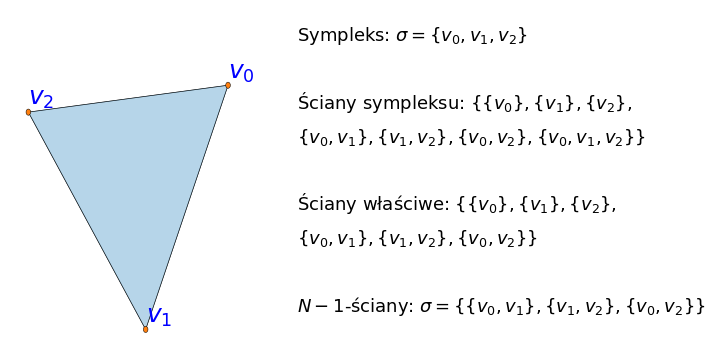

In [9]:
# Tworzenie sympleksu
simplices = [[0],[1], [0,1], [0,2], [1,2], [0,1,2]]

# Tworzenie struktury wykresu
fig, axs = plt.subplots(1, 2, figsize=(10, 5)) 

# Rysowanie sympleksu
draw_2d_simplicial_complex(simplices, ax=axs[0], SEED=6, ANNOT=True, ANNOTsize=25)

# Annotacje kolejnych rodzajów ścian sympleksu
axs[1].annotate(r'Sympleks: $\sigma = \{v_0, v_1,v_2\}$', (0.1,0.9), fontsize=18)
axs[1].annotate(r'Ściany sympleksu: $\{\{v_0\}, \{v_1\},\{v_2\},$', (0.1,0.7), fontsize=18)
axs[1].annotate(r'$\{v_0, v_1\},\{v_1,v_2\}, \{v_0, v_2\}, \{v_0, v_1,v_2\}\}$', (0.1,0.6), fontsize=18)
axs[1].annotate(r'Ściany właściwe: $\{\{v_0\},\{v_1\},\{v_2\},$',(0.1,0.4), fontsize=18)
axs[1].annotate(r'$\{v_0, v_1\},\{v_1,v_2\}, \{v_0, v_2\}\}$', (0.1,0.3), fontsize=18)
axs[1].annotate(r'$N-1$-ściany: $\sigma = \{\{v_0, v_1\},\{v_1,v_2\}, \{v_0, v_2\}\}$', (0.1,0.1), fontsize=18)

# Wyłączenie osi wykresu
axs[1].axis("off")

# Wyświetlenie i zapisanie wykresu
plt.tight_layout()
#plt.savefig("Ścianykompleksu.pdf", bbox_inches='tight')
plt.show()

## Przykładowe kompleksy symplicjalne

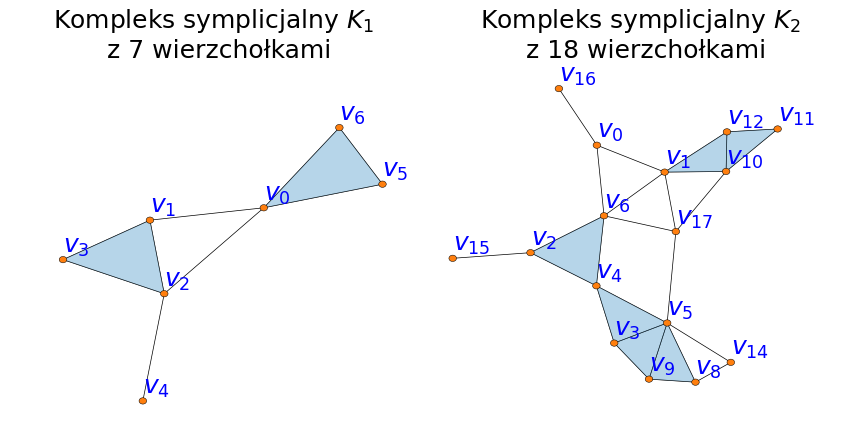

In [72]:
# Tworzenie kompleksów
simplices1 = [[0,1],[1,2,3],[2,4],[0,2],[0,5,6]]
simplices2 = [[0,1], [1,6], [2,4], [3,4,5], [5,8,9], [3,5,9],[4,6], [5,17],[17,10],[10,11,12] ,[2,4,6], [0,6], 
              [6,17], [8,14], [5,14], [1,17], [1,10,12],[2,15], [0,16]]

# Tworzenie struktury wykresu
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Wykres 1 - przykładowy kompleks symplicjalny z 7 punktami
draw_2d_simplicial_complex(simplices1, ax=axes[0], SEED=10, ANNOT=True, ANNOTsize=25)
axes[0].set_title(f"Kompleks symplicjalny $K_1$ \n z 7 wierzchołkami", fontsize=25, pad=10)

# Wykres 2 - przykładowy kompleks symplicjalny z 17 punktami
draw_2d_simplicial_complex(simplices2, ax=axes[1], SEED=15, ANNOT=True, ANNOTsize=25)
axes[1].set_title(f"Kompleks symplicjalny $K_2$ \n z 18 wierzchołkami", fontsize=25, pad=10)

# Wyświetlenie i zapisanie wykresu
plt.tight_layout()
#plt.savefig("PrzykładKompleksu.pdf", bbox_inches='tight')
plt.show()

## Przykład błędnych kompleksów symplicjalnych

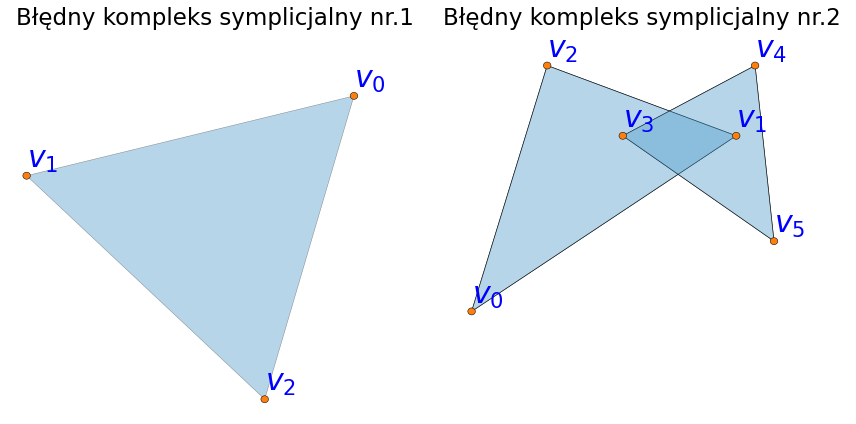

In [79]:
# Tworzenie kompleksów
simplices1=[[0,1,2]]
simplices2 = [[0,1,2],[3,4,5]]

# Tworzenie struktury wykresu
fig, axs = plt.subplots(1, 2, figsize=(12, 6)) 

# Wykres 1 - kompleks niezawierający swoich ścian
draw_2d_simplicial_complex(simplices1, ax=axs[0], ANNOT=True, WRONG=True, ANNOTsize=30)
axs[0].set_title("Błędny kompleks symplicjalny nr.1", fontsize=23)

# Wykres 2 - kompleks, w którym sympleksu przecinają się nie w swoich ścianach
draw_2d_simplicial_complex(simplices2, ax=axs[1], ANNOT=True, ANNOTsize=30, fixedpos = {0:(-9/10,-5/10), 1:(5/10,1/2), 
                                                                                        2:(-5/10,9/10), 3:(-1/10,5/10), 
                                                                                        4:(6/10,9/10), 5:(7/10, -1/10)})
axs[1].set_title("Błędny kompleks symplicjalny nr.2", fontsize=23)

# Wyświetlenie i zapisanie wykresu
plt.tight_layout()
#plt.savefig("Błednekompleksy.pdf", bbox_inches='tight')
plt.show()

## Przykład sympleksów zorientowanych

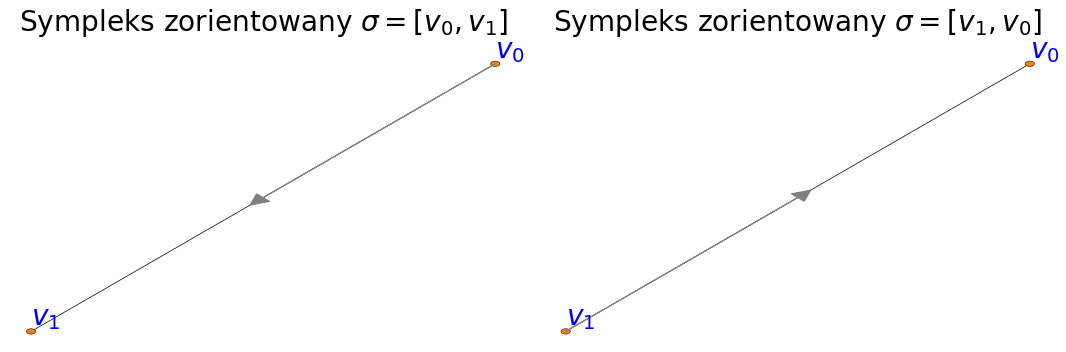

In [44]:
# Tworzenie sympleksów
simplices = [[0,1]]
simplices2 = [[1,0]]

# Tworzenie struktury wykresu
fig, axs = plt.subplots(1, 2, figsize=(15, 5)) 

# Wykres 1 - sympleks zorientowany 
draw_2d_simplicial_complex(simplices, ax=axs[0], SEED=1, ORIENT=True, ANNOT=True, ANNOTsize=28)
axs[0].set_title(r'Sympleks zorientowany $\sigma = [v_0, v_1]$', fontsize=28, pad=20)

# Wykres 2 - sympleks zorientowany z przeciwnym kierunkiem
draw_2d_simplicial_complex(simplices2, ax=axs[1], SEED=1, ORIENT=True, ANNOT=True, ANNOTsize=28)
axs[1].set_title(r'Sympleks zorientowany $\sigma = [v_1, v_0]$', fontsize=28, pad=20)

# Wyświetlenie i zapisanie wykresu
plt.tight_layout()
#plt.savefig("Sympleksyzorientowane.pdf", bbox_inches='tight')
plt.show()

## Przykład kompleksu łańcuchowego

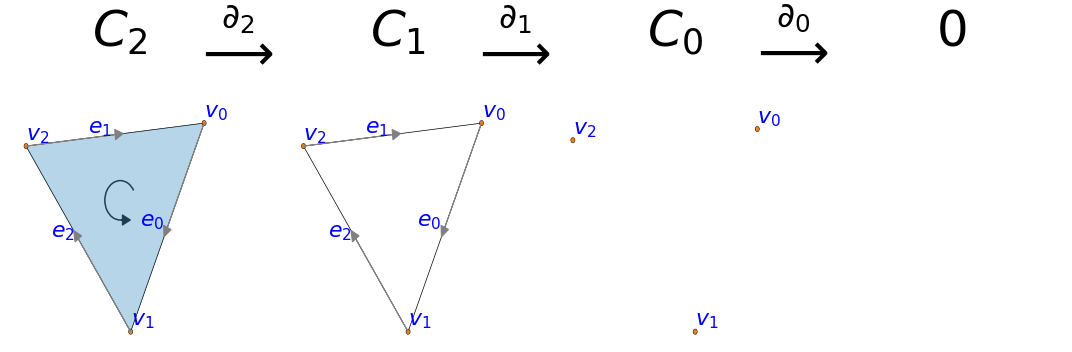

In [41]:
# Tworzenie kompleksów symplicjalnych
simplices0 = []
simplices1 = [[0],[1], [2]]
simplices2 = [[0,1], [2,0], [1,2]]
simplices3 = [[0,1], [2,0], [1,2], [0,1,2]]

# Tworzenie struktury wykresu
fig, axs = plt.subplots(1, 4, figsize=(15, 5)) 

# Wykres 1 - pierwszy kompleks zorientowany
draw_2d_simplicial_complex(simplices3, ax=axs[0], SEED=6, ORIENT=True, ORIENTT=True, ANNOTedges=True, ANNOT=True, ANNOTsize=22)
axs[0].set_title(r'$C_2$', fontsize=50)
axs[0].annotate(r'$ \overset{\partial_2}{\longrightarrow} $', xy=(1, 0.96), xycoords='axes fraction', fontsize=50, ha='center')

# Wykres 2 - drugi kompleks zorientowany
draw_2d_simplicial_complex(simplices2, ax=axs[1], SEED=6, ORIENT=True, ANNOTedges=True, ANNOT=True, ANNOTsize=22)
axs[1].set_title(r'$C_1$', fontsize=50)
axs[1].annotate(r'$ \overset{\partial_1}{\longrightarrow} $', xy=(1, 0.96), xycoords='axes fraction', fontsize=50, ha='center')

# Wykres 1 - trzeci kompleks zorientowany
draw_2d_simplicial_complex(simplices1, ax=axs[2], SEED=6, ORIENT=True, ANNOT=True, ANNOTsize=22)
axs[2].set_title(r'$C_0$', fontsize=50)
axs[2].annotate(r'$ \overset{\partial_0}{\longrightarrow} $', xy=(1, 0.96), xycoords='axes fraction', fontsize=50, ha='center')

# Wykres 4 - pusty kompleks
draw_2d_simplicial_complex(simplices0, ax=axs[3])
axs[3].set_title("0", fontsize=50)

# Wyświetlenie i zapisanie wykresu
plt.tight_layout()
#plt.savefig("PrzykładŁańcucha.pdf", bbox_inches='tight')
plt.show()

## Błędna filtracja

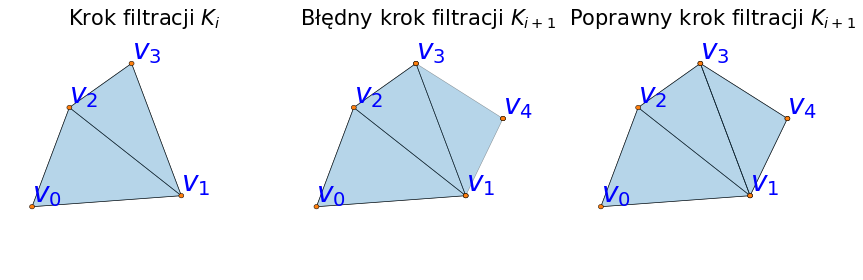

In [28]:
# Tworzenie dwóch kompleksów symplicjalnych 
simplices0 = [[0,1,2], [1,2,3]]
simplices1 = [[0,1,2], [1,2,3], [4]]
simplices2 = [[1,3,4]]

# Tworzenie struktury wykresu
fig, axs = plt.subplots(1, 3, figsize=(12, 4)) 

# Wykres 1 - Zwykły kompleks symplicjalny
draw_2d_simplicial_complex(simplices0, ax=axs[0], ANNOT=True, 
                           fixedpos = {0:(-9/10,-5/10), 1:(3/10,-0.4), 2:(-6/10,4/10), 3:(-1/10,8/10)}, ANNOTsize=28)
                                                                          
axs[0].set_title(f"Krok filtracji $K_i$", fontsize=21)

# Wykres 3 - Błędny krok filtracji
draw_2d_simplicial_complex(simplices1, ax=axs[1], ANNOT=True, fixedpos = {0:(-9/10,-5/10), 
                                                                          1:(3/10,-0.4), 
                                                                          2:(-6/10,4/10), 
                                                                          3:(-1/10,8/10), 4:(6/10,3/10)}, ANNOTsize=28)
draw_2d_simplicial_complex(simplices2, ax=axs[1], fixedpos = {1:(3/10,-0.4), 3:(-1/10,8/10), 4:(6/10,3/10)}, 
                           WRONG=True, ANNOTsize=28)
axs[1].set_title(r"Błędny krok filtracji $K_{i+1}$", fontsize=21)

# Wykres 3 - Poprawny krok filtracji
draw_2d_simplicial_complex(simplices1, ax=axs[2], ANNOT=True, fixedpos = {0:(-9/10,-5/10), 
                                                                          1:(3/10,-0.4), 
                                                                          2:(-6/10,4/10), 
                                                                          3:(-1/10,8/10), 4:(6/10,3/10)}, ANNOTsize=28)
draw_2d_simplicial_complex(simplices2, ax=axs[2], fixedpos = {1:(3/10,-0.4), 3:(-1/10,8/10), 4:(6/10,3/10)}, ANNOTsize=28)
axs[2].set_title(r"Poprawny krok filtracji $K_{i+1}$", fontsize=21)

# Wyświetlenie i zapisanie wykresu
plt.tight_layout()
#plt.savefig("Filtracjaprzypadki.pdf", bbox_inches='tight')
plt.show()

## Przykładowa filtracja

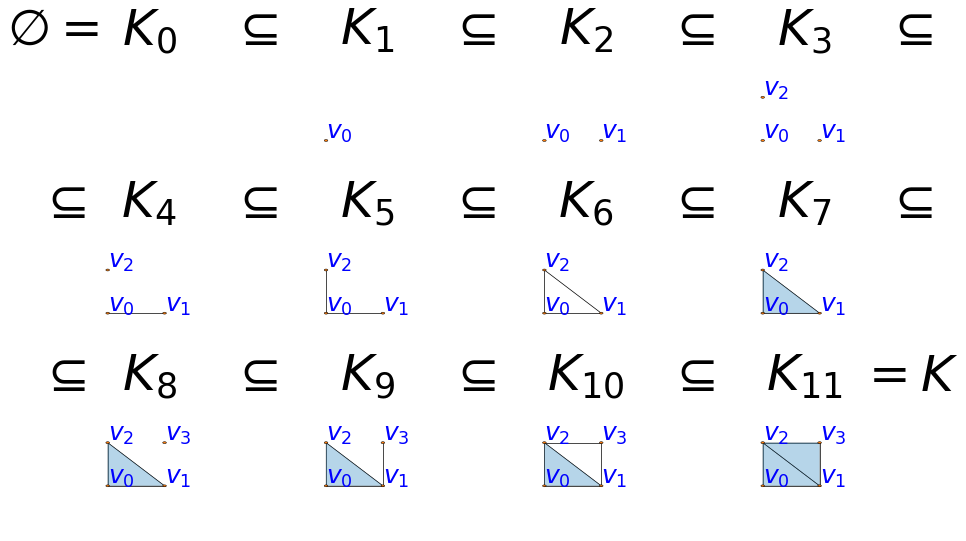

In [18]:
# Tworzenie listy sympleksów
simplices = [[0],[1], [2], [0,1], [2,0], [1,2], [0,1,2], [3], [1,3], [3,2],[1,2,3]]

# Tworzenie struktury wykresu
fig, axes = plt.subplots(3, 4, figsize=(15, 9))
axes = axes.flatten() 

# Pętla tworząca kolejne etapy filtracji
for n in range(len(simplices)+1):
    
    # Tworzenie kompleksu symplicjalnego
    draw_2d_simplicial_complex(simplices[0:n], fixedpos= {0:(0,0), 1:(5/8,0), 2:(0,9/10), 3:(5/8,9/10)},
                               ax=axes[n], SEED=8, ANNOT=True, ANNOTsize=25)
    
    # Zmiana parametrów wykresu
    axes[n].set_xlim(-1, 1)
    axes[n].set_ylim(-1, 2)
    
    # Dodanie podpisów dla kolejnych kroków filtracji
    axes[n].annotate(r"   $K_{{{}}}$".format(n), xy=(0.2, 2), fontsize=50, ha='center')
    
    if n!=11:
        axes[n].annotate(r"       $\subseteq$", xy=(1, 2), fontsize=50, ha='center')
    else:
        axes[n].annotate(r"       $ = K$", xy=(1, 2), fontsize=50, ha='center')
        
    if n % 4 == 0 and n != 0:
        axes[n].annotate(r"$\subseteq$", xy=(-0.5, 2), fontsize=50, ha='center')
    elif n % 4 == 0 and n == 0:
        axes[n].annotate(r"$\emptyset=$", xy=(-0.6, 2), fontsize=50, ha='center')

# Wyświetlenie i zapisanie wykresu      
#plt.savefig("Filtracjasymplicjalna.pdf", bbox_inches='tight')
plt.show()

## Przykład klasy homologii

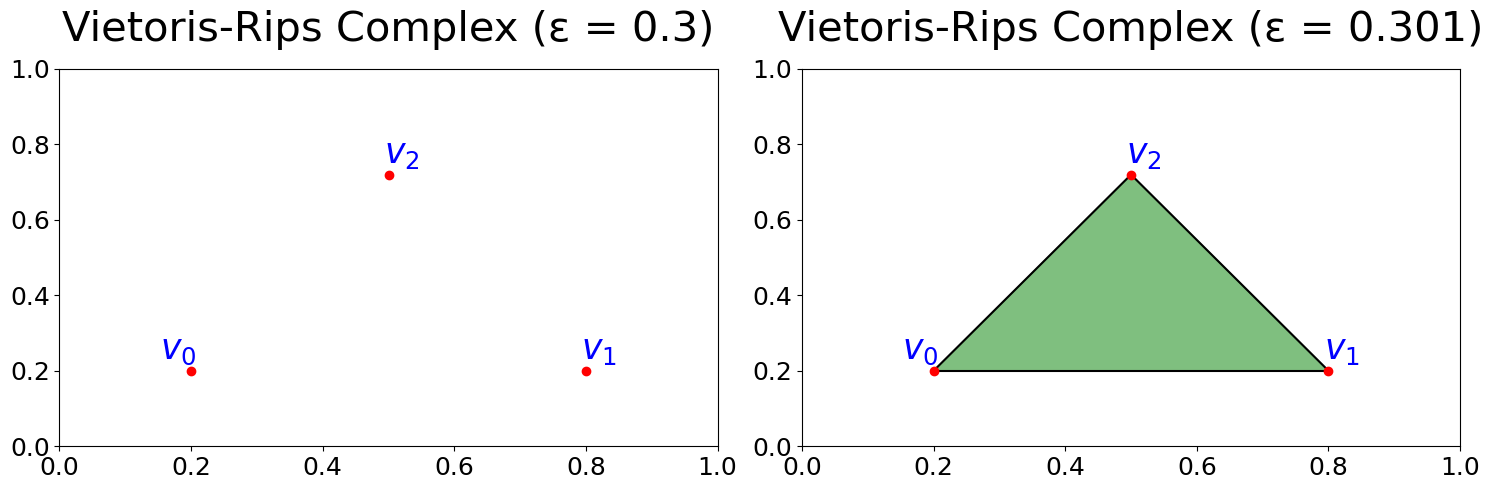

In [120]:
import numpy as np
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import gudhi as gd

# Lista punktów
points = np.array([[0.2, 0.2],[0.8, 0.2],[0.5, 0.71962]])

# Lista indeksów punktów
label=[f"$v_{{{0}}}$", f"$v_{{{1}}}$",f"$v_{{{2}}}$"]

# Macierz odległości
dist_matrix = distance_matrix(points, points)

# Lista parametrów
epsilon_list = [0.3, 0.301]
r = [m/2 for m in epsilon_list]

# Tworzenie struktury wykresu
fig, axes = plt.subplots(1, len(epsilon_list), figsize=(15, 5))

# Pętla tworząca dwa kompleksy 
for idx, threshold in enumerate(epsilon_list):
    
    # Wybór podwykresu(subplota)
    ax = axes[idx]
    
    # Tworzenie kompleksu Vietorisa-Ripsa
    rips = gd.RipsComplex(points=points, max_edge_length=2*threshold)
    
    # Wyizolowanie krawędzi i trójkątów kompleksu
    simplex_tree = rips.create_simplex_tree(max_dimension=2)
    edges = [s for s in simplex_tree.get_skeleton(1) if len(s[0]) == 2]
    triangles = [s for s in simplex_tree.get_skeleton(2) if len(s[0]) == 3]

    # Wykres punktowy 
    ax.scatter(points[:, 0], points[:, 1], color='red', zorder=2)
    
    # Podpisanie punktów
    for i, (x, y) in enumerate(points):
        if i==0:
            ax.annotate(label[i], (x, y), textcoords="data", xytext=(x- 0.02, y + 0.03), ha='center', 
                        fontsize=25, zorder=3, color='blue')
        else:
            ax.annotate(label[i], (x, y), textcoords="data", xytext=(x+ 0.02, y + 0.03), ha='center', 
                        fontsize=25, zorder=3, color='blue')
            
    # Naniesienie krawędzi na wykres
    for edge, _ in edges:
        p1, p2 = points[edge[0]], points[edge[1]]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k-', zorder=1)

    # Naniesienie trójkątów na wykres
    for tri, _ in triangles:
        p1, p2, p3 = points[tri[0]], points[tri[1]], points[tri[2]]
        ax.fill([p1[0], p2[0], p3[0]], [p1[1], p2[1], p3[1]], color='green', alpha=0.5)

    # Dodanie własności wykresów
    ax.set_title(f"Vietoris-Rips Complex (ε = {threshold})", fontsize=30, pad=20)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)

# Wyświetlenie i zapisanie wykresu
plt.tight_layout()
#plt.savefig("Klasahomologii.pdf", bbox_inches='tight')
plt.show()

## Wada diagramów persystencji

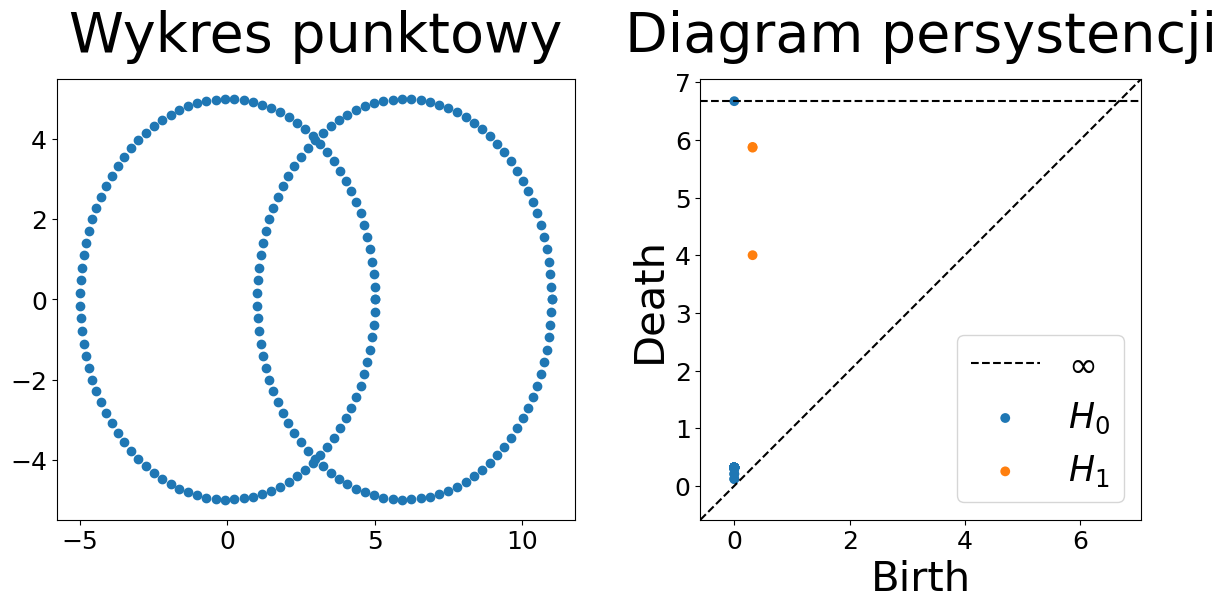

In [90]:
import numpy as np
from ripser import ripser
from persim import plot_diagrams
import matplotlib.pyplot as plt

# Parametry okręgów, promień i przesunięcie
translate=6
radius=5

# Dodanie wartości theta by móc tworzyć okręgi 
theta = np.linspace(0, 2 * np.pi, 100)

# Tworzenie okręgu
x1 = radius * np.cos(theta)
y1 = radius * np.sin(theta)

# Tworzenie identycznego okręgu przesuniętego na osi x o wartość 6
x2 = translate + radius * np.cos(theta)
y2 = radius * np.sin(theta)

# Połączenie każdego okręgu w jeden obiekt
x=np.concatenate((x1, x2))
y=np.concatenate((y1, y2))

# Tworzenie struktury wykresu
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Wykres 1 - punktowy okręgów
axes[0].scatter(x, y)
axes[0].set_title("Wykres punktowy", fontsize=40, pad=20)
axes[0].tick_params(axis='x', labelsize=18)
axes[0].tick_params(axis='y', labelsize=18)

# Wykres 2 - diagram persystencji z podpisanymi osiami
diagrams = ripser(np.column_stack((x, y)))['dgms']
plot_diagrams(diagrams, ax=axes[1], show=False, size=50)
axes[1].set_title("Diagram persystencji", fontsize=40, pad=20)
axes[1].set_xlabel("Birth", fontsize=30)
axes[1].set_ylabel("Death", fontsize=30)
axes[1].legend(prop={'size': 25})
axes[1].tick_params(axis='x', labelsize=18)
axes[1].tick_params(axis='y', labelsize=18)
    
# Wyświetlenie i zapisanie wykresu    
plt.tight_layout()
#plt.savefig("PokrywajacesieH1.pdf", bbox_inches='tight')
plt.show()

## Przykładowe diagramy persystencji

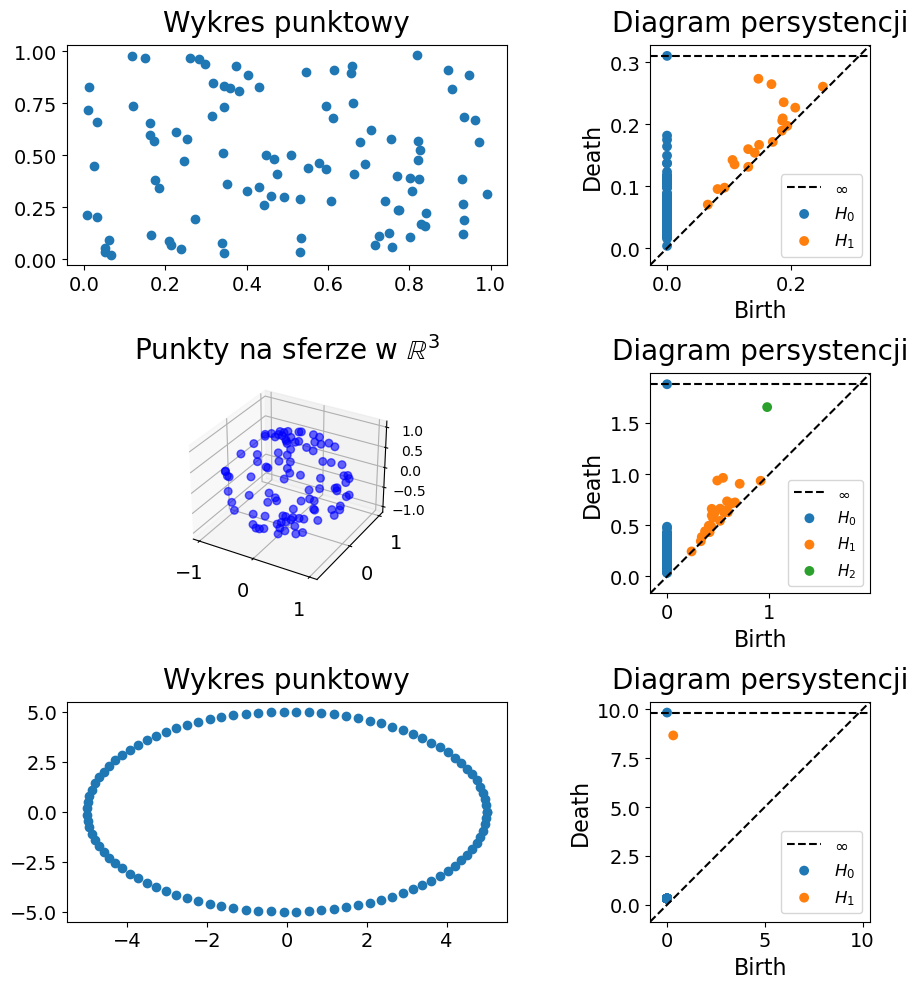

In [100]:
import numpy as np
from ripser import ripser
from persim import plot_diagrams
import matplotlib.pyplot as plt

# Tworzenie 100 losowych punktów
data1 = np.random.random((100, 2))

# Tworzenie okręgu o promieniu 5
theta1 = np.linspace(0, 2 * np.pi, 100)
xx = 5 * np.cos(theta1)
yy = 5 * np.sin(theta1)
data2 = np.column_stack((xx, yy))

# Tworzenie losowych punktów sfery 
phi = np.random.uniform(0, np.pi, 100)
theta2 = np.random.uniform(0, 2 * np.pi, 100)
x = np.sin(phi) * np.cos(theta2)
y = np.sin(phi) * np.sin(theta2)
z = np.cos(phi)
data3 = np.vstack((x, y, z)).T

# Tworzenie struktury wykresu
fig = plt.figure(figsize=(10, 10))

# Wykres 1 - punktowy z losowych punktów
ax1 = fig.add_subplot(3, 2, 1)
ax1.scatter(data1[:, 0], data1[:, 1])
ax1.set_title("Wykres punktowy", fontsize=20, pad=10)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

# Wykres 2 - diagram persystencji dla losowych punktów
ax2 = fig.add_subplot(3, 2, 2)
diagrams1 = ripser(data1)['dgms']
plot_diagrams(diagrams1, ax=ax2, show=False, size=50)
ax2.set_title("Diagram persystencji", fontsize=20, pad=10)
ax2.set_xlabel("Birth", fontsize=16)
ax2.set_ylabel("Death", fontsize=16)
ax2.legend(prop={'size': 12})
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)

# Wykres 3 - Wykres losowych punktów sfery 
ax3 = fig.add_subplot(3, 2, 3, projection='3d')
ax3.scatter(x, y, z, c='b', alpha=0.6, s=30)
ax3.set_title("Punkty na sferze w $\\mathbb{R}^3$", fontsize=20, pad=10)
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)

# Wykres 4 - diagram persystencji dla losowych punktów sfery 
ax4 = fig.add_subplot(3, 2, 4)
diagrams3 = ripser(data3, maxdim=2)['dgms']
plot_diagrams(diagrams3, ax=ax4, show=False, size=50)
ax4.set_title("Diagram persystencji", fontsize=20, pad=10)
ax4.set_xlabel("Birth", fontsize=16)
ax4.set_ylabel("Death", fontsize=16)
ax4.legend(prop={'size': 11})
ax4.tick_params(axis='x', labelsize=14)
ax4.tick_params(axis='y', labelsize=14)

# Wykres 5 - wykres punktowy dla okręgu
ax5 = fig.add_subplot(3, 2, 5)
ax5.scatter(xx, yy)
ax5.set_title("Wykres punktowy", fontsize=20, pad=10)
ax5.tick_params(axis='x', labelsize=14)
ax5.tick_params(axis='y', labelsize=14)

# Wykres 6 - diagram persystencji dla okręgu
ax6 = fig.add_subplot(3, 2, 6)
diagrams = ripser(data2)['dgms']
plot_diagrams(diagrams, ax=ax6, show=False, size=50)
ax6.set_title("Diagram persystencji", fontsize=20, pad=10)
ax6.set_xlabel("Birth", fontsize=16)
ax6.set_ylabel("Death", fontsize=16)
ax6.legend(prop={'size': 12})
ax6.tick_params(axis='x', labelsize=14)
ax6.tick_params(axis='y', labelsize=14)

# Wyświetlenie i zapisanie wykresu 
plt.tight_layout()
#plt.savefig("Diagramypersystencji.pdf", bbox_inches='tight')
plt.show()

# Przykład wykresów słupkowych persystencji

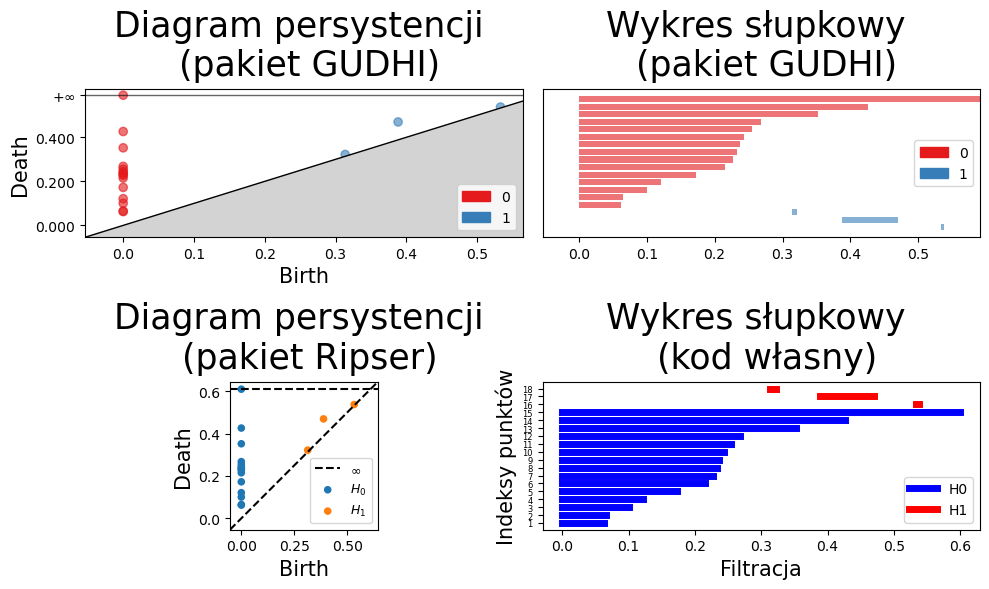

In [175]:
from ripser import ripser
from persim import plot_diagrams
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import gudhi

np.random.seed(13)
point_cloud = np.random.random((15, 2))
#data = np.random.random((15,2))

# Tworzenie kompleksu Ripsa i obliczenie homologii
rips_complex = gudhi.RipsComplex(points=point_cloud)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
diag = simplex_tree.persistence()

# Przygotowanie subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes=axes.flatten()

# Rysowanie wykresów na konkretnych osiach
gudhi.plot_persistence_diagram(diag, axes=axes[0])
axes[0].set_title("Diagram persystencji \n (pakiet GUDHI)", fontsize=25, pad=10)
axes[0].set_xlabel("Birth", fontsize=15)
axes[0].set_ylabel("Death", fontsize=15)
axes[0].tick_params(axis='x', labelsize=10)
axes[0].tick_params(axis='y', labelsize=10)

gudhi.plot_persistence_barcode(diag, axes=axes[1])
axes[1].set_title("Wykres słupkowy \n (pakiet GUDHI)", fontsize=25, pad=10)
axes[1].tick_params(axis='x', labelsize=10)
axes[1].tick_params(axis='y', labelsize=10)

diagrams = ripser(point_cloud)['dgms']
plot_diagrams(diagrams, ax=axes[2], show=False, size=30)
axes[2].set_title("Diagram persystencji \n (pakiet Ripser)", fontsize=25, pad=10)
axes[2].set_xlabel("Birth", fontsize=15)
axes[2].set_ylabel("Death", fontsize=15)
axes[2].tick_params(axis='x', labelsize=10)
axes[2].tick_params(axis='y', labelsize=10)
axes[2].legend(prop={'size': 9})

legend_elements = []
for dim, dgms in enumerate(diagrams):
    if dim == 0: 
        color = 'b'  
        label = 'H0' 
    elif dim == 1: 
        color = 'r'
        label = 'H1'

    legend_elements.append(plt.Line2D([0], [0], color=color, lw=5, label=label))

    for i, (birth, death) in enumerate(dgms):
        if death == np.inf:
            death = 0.6 
        axes[3].plot([birth, death], [i + 1 + dim * len(point_cloud)] * 2, color, lw=5)

plt.title("Wykres słupkowy \n (kod własny)", fontsize=25, pad=10)
plt.yticks(range(1, len(diagrams[0]) + len(diagrams[1]) + 1), fontsize=6)
plt.xlabel("Filtracja", fontsize=15)
plt.ylabel("Indeksy punktów", fontsize=15)
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
#plt.savefig("Barcodes.pdf", bbox_inches='tight')
plt.show()

# Liczenie odległości Wassersteina

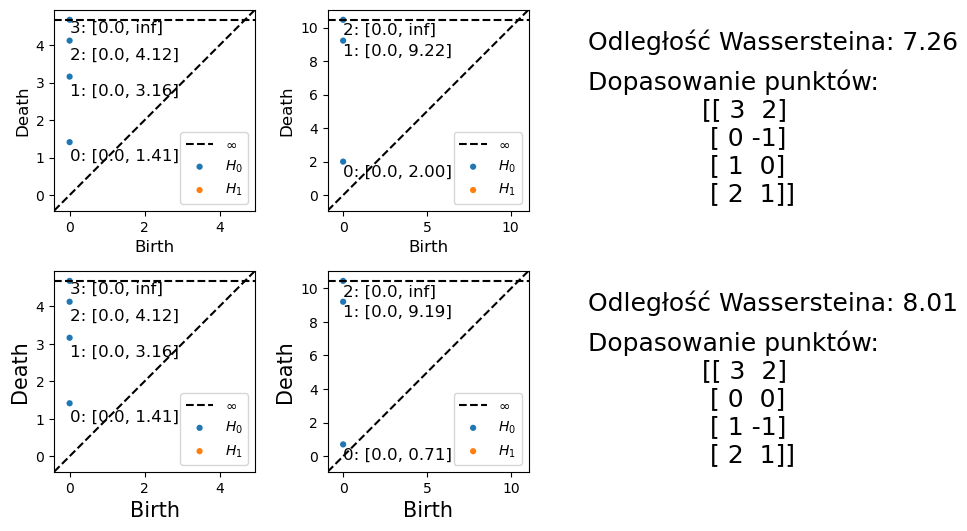

In [184]:
from gudhi.hera import wasserstein_distance
import matplotlib.pyplot as plt
import numpy as np 
from ripser import ripser
from persim import plot_diagrams
import warnings
warnings.filterwarnings("ignore")

a=np.array([[0,0], [4,1], [7,2], [-1,-1]])
b=np.array([[2,-2], [0,9], [2,0]])
d=np.array([[8,8], [1,1], [1.5,1.5]])

fig, axes = plt.subplots(2, 3, figsize=(10, 6))
plt.subplots_adjust(hspace=0.3)

plot_diagrams(ripser(a)['dgms'], ax=axes[0,0], show=False)
for i, txt in enumerate(range(len(a))):
    if np.isinf(ripser(a)['dgms'][0][i][1]):
        axes[0,0].annotate(f"{txt}: " + np.array2string(ripser(a)['dgms'][0][i], separator=', ', formatter={'float_kind':lambda x: str(x)}), 
                           (ripser(a)['dgms'][0][i][0], axes[0,0].get_ylim()[1]-0.6), fontsize=12)
    else:
        axes[0,0].annotate(f"{txt}: " + np.array2string(ripser(a)['dgms'][0][i], separator=', ', formatter={'float_kind': lambda x: f"{float(x):.2f}" if float(x) != 0 else "0.0"}),
                           (ripser(a)['dgms'][0][i][0], ripser(a)['dgms'][0][i][1]-0.5), fontsize=12)
axes[0,0].set_xlabel("Birth", fontsize=12)
axes[0,0].set_ylabel("Death", fontsize=12)

plot_diagrams(ripser(b)['dgms'], ax=axes[0,1], show=False)
for i, txt in enumerate(range(len(b))):
    if np.isinf(ripser(b)['dgms'][0][i][1]):
        axes[0,1].annotate(f"{txt}: " + np.array2string(ripser(b)['dgms'][0][i], separator=', ', formatter={'float_kind':lambda x: str(x)}), 
                           (ripser(b)['dgms'][0][i][0], axes[0,1].get_ylim()[1]-1.5), fontsize=12)
    else:
        axes[0,1].annotate(f"{txt}: " + np.array2string(ripser(b)['dgms'][0][i], separator=', ', formatter={'float_kind': lambda x: f"{float(x):.2f}" if float(x) != 0 else "0.0"}), 
                           (ripser(b)['dgms'][0][i][0], ripser(b)['dgms'][0][i][1]-0.9), fontsize=12)
axes[0,1].set_xlabel("Birth", fontsize=12)
axes[0,1].set_ylabel("Death", fontsize=12)
        
axes[0,2].annotate(f"Odległość Wassersteina: {round(wasserstein_distance(ripser(a)['dgms'][0], ripser(b)['dgms'][0], matching=True, internal_p=2)[0], 2)}", (0,0.8), fontsize=18)
axes[0,2].annotate("Dopasowanie punktów:", (0,0.6), fontsize=18)
axes[0,2].annotate(wasserstein_distance(ripser(a)['dgms'][0], ripser(b)['dgms'][0], matching=True, order=1,
                                        internal_p=2)[1], (0.5,0.05), fontsize=18)
axes[0,2].axis("off")

plot_diagrams(ripser(a)['dgms'], ax=axes[1,0], show=False)
for i, txt in enumerate(range(len(a))):
    if np.isinf(ripser(a)['dgms'][0][i][1]):
        axes[1,0].annotate(f"{txt}: " + np.array2string(ripser(a)['dgms'][0][i], separator=', ', formatter={'float_kind':lambda x: str(x)}), 
                           (ripser(a)['dgms'][0][i][0], axes[1,0].get_ylim()[1]-0.6), fontsize=12)
    else:
        axes[1,0].annotate(f"{txt}: " + np.array2string(ripser(a)['dgms'][0][i], separator=', ', formatter={'float_kind': lambda x: f"{float(x):.2f}" if float(x) != 0 else "0.0"}), 
                           (ripser(a)['dgms'][0][i][0], ripser(a)['dgms'][0][i][1]-0.5), fontsize=12)
axes[1,0].set_xlabel("Birth", fontsize=15)
axes[1,0].set_ylabel("Death", fontsize=15)
        
plot_diagrams(ripser(d)['dgms'], ax=axes[1,1], show=False)
for i, txt in enumerate(range(len(d))):
    if np.isinf(ripser(d)['dgms'][0][i][1]):
        axes[1,1].annotate(f"{txt}: " + np.array2string(ripser(d)['dgms'][0][i], separator=', ', formatter={'float_kind':lambda x: str(x)}), 
                           (ripser(d)['dgms'][0][i][0], axes[1,1].get_ylim()[1]-1.5), fontsize=12)
    else:
        axes[1,1].annotate(f"{txt}: " + np.array2string(ripser(d)['dgms'][0][i], separator=', ', formatter={'float_kind': lambda x: f"{float(x):.2f}" if float(x) != 0 else "0.0"}), 
                           (ripser(d)['dgms'][0][i][0], ripser(d)['dgms'][0][i][1]-0.9), fontsize=12)
axes[1,1].set_xlabel("Birth", fontsize=15)
axes[1,1].set_ylabel("Death", fontsize=15)

axes[1,2].annotate(f"Odległość Wassersteina: {round(wasserstein_distance(ripser(a)['dgms'][0], ripser(d)['dgms'][0], matching=True, internal_p=2)[0], 2)}", (0,0.8), fontsize=18)
axes[1,2].annotate("Dopasowanie punktów:", (0,0.6), fontsize=18)
axes[1,2].annotate(wasserstein_distance(ripser(a)['dgms'][0], ripser(d)['dgms'][0], matching=True, order=1,
                                        internal_p=2)[1], (0.5,0.05), fontsize=18)
axes[1,2].axis("off")

#plt.savefig("Odległość Wassersteina.pdf", bbox_inches='tight')
plt.show()

## Przykładowa funkcja namiotowa

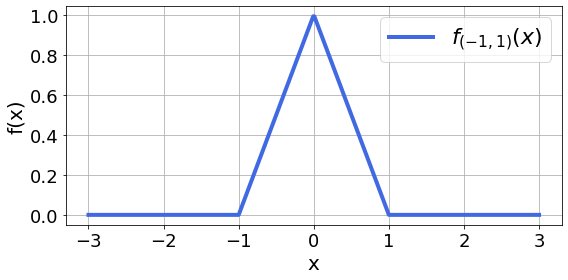

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parametry funkcji
b = -1; d = 1

# Wzór funkcji
def tent_function(x, b, d):
    if x < b or x > d:
        return 0
    elif x <= (b + d) / 2:
        return x - b
    else:
        return d - x

# Wartości x i y
x = np.linspace(b - 2, d + 2, 400)
y = [tent_function(a, b, d) for a in x]

#Tworzenie wykresu
plt.figure(figsize=(8, 4))

plt.plot(x, y, label=fr'$f_{{({-1},{1})}}(x)$', color='royalblue', lw=4)
plt.legend(prop={'size': 22})
plt.xlabel('x', fontsize=20)
plt.ylabel('f(x)', fontsize=20)
plt.grid(True)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
    
# Wyświetlenie i zapisanie wykresu
plt.tight_layout()
#plt.savefig("Funkcjanamiotowa.pdf", bbox_inches='tight')
plt.show()

## Przykładowa funkcja namiotowa dla diagramu persystencji

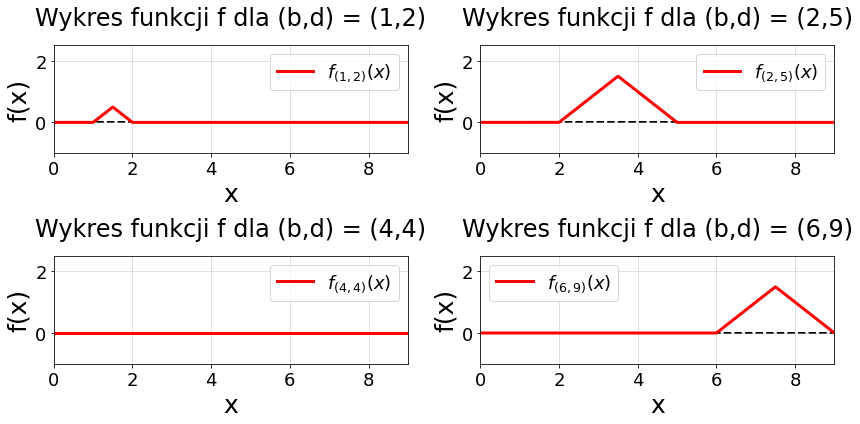

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Definicja funkcji namiotowej dla obiektów typu np.array
def f(x, b, d):
    result = np.zeros_like(x)
    mask1 = (x > b) & (x < ((b + d) / 2))
    mask2 = (x >= ((b + d) / 2)) & (x < d)
    result[mask1] = x[mask1] - b
    result[mask2] = -x[mask2] + d
    return result

# Wartości na osi x
x = np.linspace(0, 10, 1000)

# Wybrane pary (b,d)
params = [(1, 2), (2, 5), (4, 4), (6, 9)] 

# Tworzenie wykresu
plt.figure(figsize=(12, 6))
for i, (b, d) in enumerate(params):
    plt.subplot(2, 2, i + 1) 
    plt.plot(x, f(x, b, d), label=fr'$f_{{({b},{d})}}(x)$', lw=3, color="red")
    plt.xlabel("x", fontsize=25)
    plt.ylabel("f(x)", fontsize=25)
    plt.axhline(y=0, color='black', linestyle='--', linewidth=2, zorder=1)
    plt.ylim(-1,2.5)
    plt.xlim(0,9)
    plt.grid(True, alpha=0.5)
    plt.title(f"Wykres funkcji f dla (b,d) = ({b},{d})", fontsize=24, pad=20)
    plt.legend(prop={'size': 18})
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    
# Wyświetlenie i zapisanie wykresu
plt.tight_layout()
#plt.savefig("Funkcjanamiotowaf.pdf", bbox_inches='tight')
plt.show()

## Przykładowy krajobraz persystencji

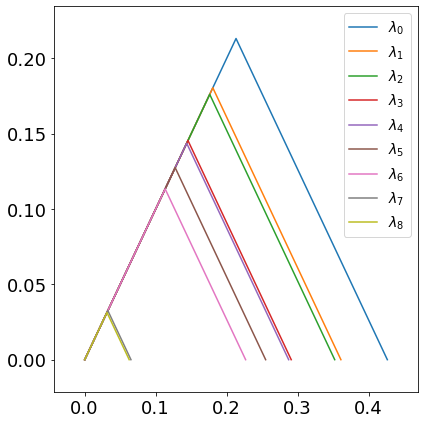

In [12]:
import numpy as np
from persim import PersLandscapeExact
from persim.landscapes import plot_landscape_simple
from ripser import ripser
import matplotlib.pyplot as plt
from persim import plot_diagrams

plt.figure(figsize=(6, 6))

# Losowanie punktów
np.random.seed(13)
point_cloud = np.random.random((10,2))

# Tworzenie diagramu persystencji
diagrams = ripser(point_cloud)['dgms']

# Wykres krajobrazu persystencji
ple = PersLandscapeExact(dgms=diagrams, hom_deg=0)
plot_landscape_simple(ple)
plt.legend(prop={'size': 14})
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

# Wyświetlenie i zapisanie wykresu
plt.tight_layout()
#plt.savefig("Przykładowykrajobraz.pdf", bbox_inches='tight')
plt.show()

## Przykład diagramu persystencji i jego krajobrazu

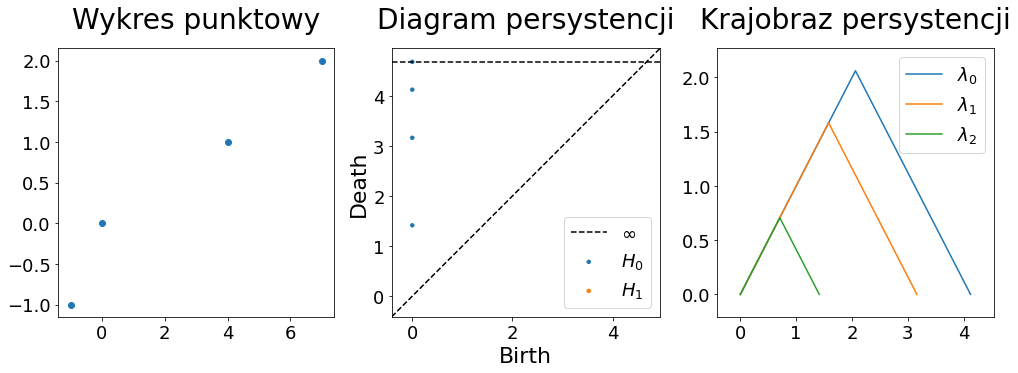

In [1]:
import numpy as np
from persim import PersLandscapeExact
from persim.landscapes import plot_landscape_simple
from ripser import ripser
import matplotlib.pyplot as plt
from persim import plot_diagrams

# Wybór punktów
point_cloud = np.array([[0,0], [4,1], [7,2], [-1,-1]])

# Tworzenie diagramu persystencji i krajobrazu persystencji
diagrams = ripser(point_cloud)['dgms']
ple = PersLandscapeExact(dgms=diagrams, hom_deg=0)

# Tworzenie struktury wykresu
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# Wykres 1 - punktowy
axes[0].scatter(point_cloud[:, 0], point_cloud[:, 1])
axes[0].set_title("Wykres punktowy", fontsize=28, pad=20)
axes[0].tick_params(axis='x', labelsize=18)
axes[0].tick_params(axis='y', labelsize=18)

# Wykres 2 - diagram persystencji
plot_diagrams(diagrams, ax=axes[1], show=False)
axes[1].set_title("Diagram persystencji", fontsize=28, pad=20)
axes[1].legend(prop={'size': 18})
axes[1].tick_params(axis='x', labelsize=18)
axes[1].tick_params(axis='y', labelsize=18)
axes[1].set_xlabel("Birth", fontsize=22)
axes[1].set_ylabel("Death", fontsize=22)

# Wykres 3 - krajobraz persystencji
plot_landscape_simple(ple, ax=axes[2])
axes[2].set_title("Krajobraz persystencji", fontsize=28, pad=20)
axes[2].legend(prop={'size': 18})
axes[2].tick_params(axis='x', labelsize=18)
axes[2].tick_params(axis='y', labelsize=18)

# Wyświetlenie i zapisanie wykresu
plt.tight_layout()
#plt.savefig("diagramikrajobraz.pdf", bbox_inches='tight')
plt.show()

## Przykład reprezentacji graficznych

In [1]:
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
import numpy as np
from persim import PersLandscapeExact
import gudhi
from persim.landscapes import plot_landscape_simple
import math

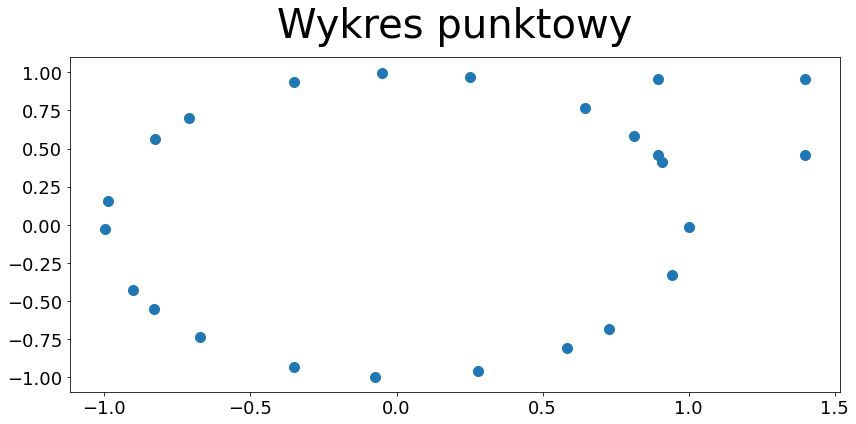

In [2]:
# Tworzenie ziarna
np.random.seed(42)  

# Tworzenie danych na okręgu
def circle_points(center, angles, radius, n):
    return np.stack([center[0] + radius*np.cos(angles), center[1] + radius*np.sin(angles)], axis=1)
angles = np.linspace(0, 2*np.pi, 20, endpoint=False)
circle_points = np.stack([np.cos(angles), np.sin(angles)], axis=1)

# Dodanie szumu i normalizacja wartości
noise = 0.1 * np.random.randn(*circle_points.shape)
noisy_circle_points = circle_points + noise
radii = np.linalg.norm(noisy_circle_points, axis=1, keepdims=True)
noisy_circle_points = noisy_circle_points / radii  # przeskalowujemy na promień ~1

# Tworzenie danych w kwadracie
square_points = np.array([[0.897, 0.457],[0.897, 0.957],[1.397, 0.957],[1.397, 0.457]])

# Tworzenie jednego zbioru punktów/danych
point_cloud = np.vstack([noisy_circle_points, square_points])

# Tworzenie wykresu i jego zapisanie 
plt.figure(figsize=(12,6))
plt.scatter(point_cloud[:, 0], point_cloud[:, 1], s=100)
plt.title("Wykres punktowy", fontsize=40, pad=20)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

plt.tight_layout()
#plt.savefig("Wykrespunktowy.pdf", bbox_inches='tight')
plt.show()

C:\Users\winal\anaconda3\lib\site-packages\gudhi\persistence_graphical_tools.py:112: UserWarning: usetex mode requires dvipng.
  warnings.warn("usetex mode requires dvipng.")


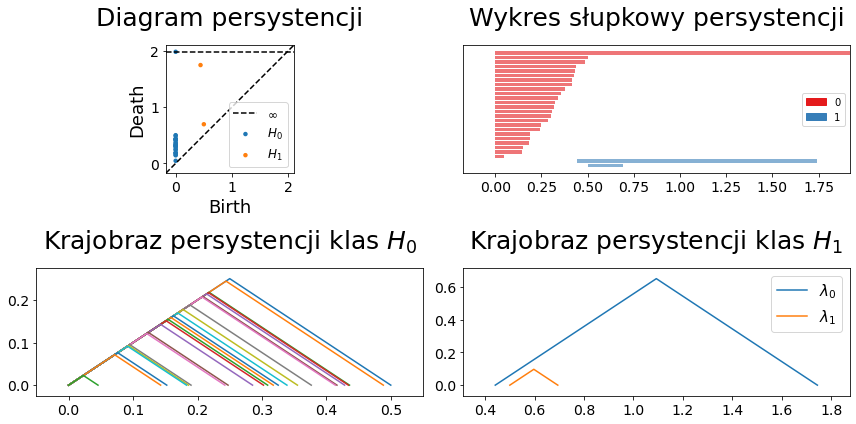

In [3]:
# Tworzenie struktury wykresu
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes=axes.flatten()

# Wykres 1 - diagram persystencji
diagrams = ripser(point_cloud, maxdim=1)['dgms']
plot_diagrams(diagrams, ax=axes[0], show=False)
axes[0].set_title("Diagram persystencji", fontsize=25, pad=20)
axes[0].set_xlabel("Birth", fontsize=18)
axes[0].set_ylabel("Death", fontsize=18)
axes[0].legend(prop={'size': 12})
axes[0].tick_params(axis='x', labelsize=14)
axes[0].tick_params(axis='y', labelsize=14)

# Wykres 3 - wykres słupkowy persystencji
rips_complex = gudhi.RipsComplex(points=point_cloud)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
diag = simplex_tree.persistence()
gudhi.plot_persistence_barcode(diag, axes=axes[1])
axes[1].set_title("Wykres słupkowy persystencji", fontsize=25, pad=20)
axes[1].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='y', labelsize=14)

# Wykres 3 - krajobraz persystencji wymiaru 0
plot_landscape_simple(PersLandscapeExact(dgms=diagrams, hom_deg=0), ax=axes[2])
axes[2].legend_.remove()
axes[2].set_title("Krajobraz persystencji klas $H_0$", fontsize=25, pad=20)
axes[2].tick_params(axis='x', labelsize=14)
axes[2].tick_params(axis='y', labelsize=14)

# Wykres 4 - krajobraz persystencji wymiaru 1
plot_landscape_simple(PersLandscapeExact(dgms=diagrams, hom_deg=1), ax=axes[3])
axes[3].set_title(r"Krajobraz persystencji klas $H_1$", fontsize=25, pad=20)
axes[3].legend(prop={'size': 15})
axes[3].tick_params(axis='x', labelsize=14)
axes[3].tick_params(axis='y', labelsize=14)

# Wyświetlenie i zapisanie wykresu
plt.tight_layout()
#plt.savefig("PrzykładWykresy.pdf", bbox_inches='tight')
plt.show()